## Compile  list of subtelomeric genes to compare

In this paper:
The Chromatin and Transcriptional Landscape of Native Saccharomyces cerevisiae Telomeres and Subtelomeric Domains
Aisha Ellahi,1 Deborah M. Thurtle,1 and Jasper Rine

Subtelomeric genes count all genes located under 20 kb of the chromosomes end.
The task is to list them from the gff files of s288c, then from yps009 annotation (although we may be missing some ends)
and compare the list.

Motivation 1: telomeric regions are fast evolving. We want to pay attention wheter these genes are more prone to switch from one chromosome to another.

Motivation 2: With the s288c/yps1009 list, check wether we have a statistical significant derepression of subtelomeric genes in disomes, from Leah RNAseq data. NB: reads were mapped to s288c, so for now better to do the analysis with lists from s288c and yps1009.

In [77]:
import gffpandas.gffpandas as gffpd
import pandas as pd
import matplotlib as plt
import numpy as np
from scipy.stats import ranksums
%matplotlib inline

In [2]:
annotation = gffpd.read_gff3('YPS1009_S288C_v5_polished.gff')
annot_s288c = gffpd.read_gff3('saccharomyces_cerevisiae_R64-3.gff')

C:\Users\user\anaconda3\lib\site-packages\gffpandas\gffpandas.py:32: DtypeWarning: Columns (1,2,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_table(self._gff_file, comment='#',


In [17]:
Chr_df = annotation.filter_feature_of_type(['chromosome'])
gene_df = annotation.filter_feature_of_type(['gene'])

Chr_df_s288c = annot_s288c.filter_feature_of_type(['chromosome'])
gene_df_s288c = annot_s288c.filter_feature_of_type(['gene'])

In [18]:
Chr_attr = Chr_df.attributes_to_columns()
gene_attr = gene_df.attributes_to_columns()

Chr_attr_288c = Chr_df_s288c.attributes_to_columns()
gene_attr_s288c = gene_df_s288c.attributes_to_columns()

In [24]:
Chr = Chr_attr[['seq_id', 'start', 'end']]

gene = gene_attr[['seq_id', 'start', 'end', 'Name',  'Alias',  'Note', 'Ontology_term', 'score', 'strand', 'phase',
       'copy_num_ID', 'coverage', 'curie', 'display', 'extra_copy_number', 'gene', 'low_identity', 'orf_classification',
       'partial_mapping', 'sequence_ID', 'valid_ORFs']]

Chr_288c = Chr_attr_288c[['seq_id', 'start', 'end']]

gene_s288c = gene_attr_s288c[['seq_id', 'start', 'end',  'Name', 'Alias', 'Note', 'Ontology_term', 'score', 'strand', 'phase',
       'attributes', 'curie', 'display', 'gene', 'orf_classification']]

In [28]:
# This code just convert the chromosome numbering to integer and remove mitochondrial genes.
def lat_to_arabic(DF):
    Latin_to_arabic = {'I': 1, 'II':2, 'III':3, 'IV':4, 'V':5, 'VI':6, 'VII':7, 'VIII':8, 'IX':9, 'X':10,
                      'XI':11, 'XII':12, 'XIII':13, 'XIV':14, 'XV':15, 'XVI':16, 'Mito': 'mitoch', 'MANY': 7}
    seq_id = DF['seq_id']
    ch = []
    contig = []
    for i in seq_id:
        chrom, cont = i.split('_')
        contig.append(cont)
        chrom = chrom.replace('chr', '')
        if '-' in chrom:
            chrom, e = chrom.split('-')
        ch.append(Latin_to_arabic[chrom])
    DF['Chromosome'] = ch
    DF['Contig'] = contig
    return DF

def clean20(DF):
    note = DF['Note']
    dis = DF['display']
    clean = []
    display = []
    for n in note:
        clean.append(n.replace('%20', ' '))
    for d in dis:
        display.append(str(d).replace('%20', ' '))
    DF['Note'] = clean
    DF['display'] = display
    return DF

def lat_to_arabic_S288(df):
    # This code just convert the chromosome numbering to integer and remove mitochondrial genes.
    Latin_to_arabic = {'I': 1, 'II':2, 'III':3, 'IV':4, 'V':5, 'VI':6, 'VII':7, 'VIII':8, 'IX':9, 'X':10,
                      'XI':11, 'XII':12, 'XIII':13, 'XIV':14, 'XV':15, 'XVI':16, 'Mito': 'mitoch'}
    chLat = df['seq_id']
    ch = []
    for chrom in chLat:
        chrom = chrom.replace('chr', '')
        ch.append(Latin_to_arabic[chrom])
    df['Chromosome'] = ch
    return df

In [29]:
Chr = lat_to_arabic(Chr)

C:\Users\user\AppData\Local\Temp\ipykernel_23120\2798434143.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['Chromosome'] = ch
C:\Users\user\AppData\Local\Temp\ipykernel_23120\2798434143.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['Contig'] = contig


In [30]:
Chr_288c = lat_to_arabic_S288(Chr_288c)

C:\Users\user\AppData\Local\Temp\ipykernel_23120\2798434143.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Chromosome'] = ch


In [32]:
gene = lat_to_arabic(gene)
gene_s288c = lat_to_arabic_S288(gene_s288c)

gene = clean20(gene)
gene_s288c = clean20(gene_s288c)

C:\Users\user\AppData\Local\Temp\ipykernel_23120\2798434143.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['Chromosome'] = ch
C:\Users\user\AppData\Local\Temp\ipykernel_23120\2798434143.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['Contig'] = contig
C:\Users\user\AppData\Local\Temp\ipykernel_23120\2798434143.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [34]:
Chr_288c

,seq_id,start,end,Chromosome
0,chrI,1.0,230218.0,1
506,chrII,1.0,813184.0,2
2423,chrIII,1.0,316620.0,3
3277,chrIV,1.0,1531933.0,4
6792,chrV,1.0,576874.0,5
8222,chrVI,1.0,270161.0,6
8870,chrVII,1.0,1090940.0,7
11431,chrVIII,1.0,562643.0,8
12784,chrIX,1.0,439888.0,9
13805,chrX,1.0,745751.0,10


In [46]:
# look for genes in the 20 kb chromosome ends
# the 5' it's gene whose end is <= 20000
# for the 3', genes start is chrX end - 20 kbp

# size of subtelomeric regions, 20kbp
size_T = 20*1000

subT_genes = []
for ind, row in gene_s288c.iterrows():
    if row['end'] <= size_T:
        subT_genes.append(row['Name'])
    elif row['start'] >= int(Chr_288c[Chr_288c['Chromosome'] == row['Chromosome']]['end'])-size_T:
        subT_genes.append(row['Name'])

In [50]:
subT_genes = gene_s288c[gene_s288c['Name'].isin(subT_genes)]
subT_genes = subT_genes[subT_genes['Chromosome'] != 'mitoch']

In [52]:
subT_genes['orf_classification'].value_counts()

Verified           145
Uncharacterized     83
Dubious             75
Name: orf_classification, dtype: int64

In [53]:
subT_genes_yps = gene[gene['Name'].isin(list(subT_genes['Name']))]
# Where are those genes in yps1009
# How do I analyse that while I don't know where the contigs align precisely?

## RNA seq statistical test for subtelomeric genes 

In [63]:
rnaseq_gml = pd.read_csv('RNAseqLeah_glm_rnaseq_annot.txt', sep = '\t', index_col=0)
rnaseq_tmm = pd.read_csv('RNAseqLeah_log2_normTMM_annotations.txt', sep = '\t', index_col=0)

In [66]:
rnaseq_tmm_subT = rnaseq_tmm[rnaseq_tmm.index.isin(list(subT_genes['Name']))]
# ~ revert the command!
rnaseq_tmm_notsubT = rnaseq_tmm[~rnaseq_tmm.index.isin(list(subT_genes['Name']))]

In [72]:
rnaseq_tmm_subT.columns         

Index(['NAME', '1 731', '2 731', '1 735', '2 735', '1 1835', '2 1835',
       '1 1839', '2 1839', '1 1845', '2 1845'],
      dtype='object')

<AxesSubplot: >

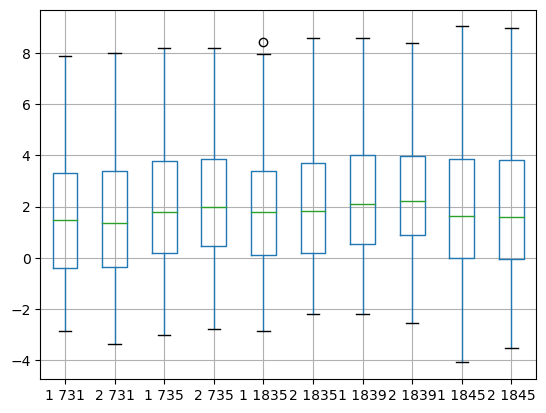

In [73]:
rnaseq_tmm_subT.boxplot(column=[ '1 731', '2 731', '1 735', '2 735', '1 1835', '2 1835',
       '1 1839', '2 1839', '1 1845', '2 1845'])  


<AxesSubplot: >

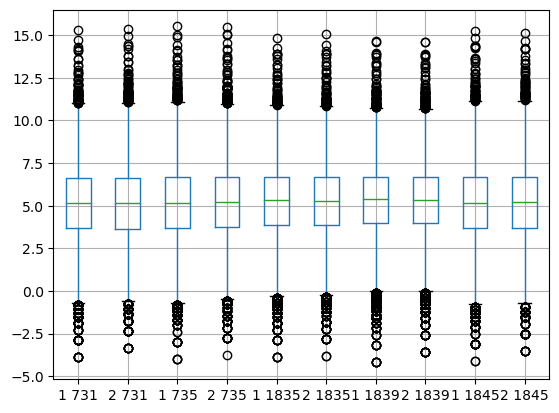

In [79]:
rnaseq_tmm_notsubT.boxplot(column=[ '1 731', '2 731', '1 735', '2 735', '1 1835', '2 1835',
       '1 1839', '2 1839', '1 1845', '2 1845'])

In [75]:
rnaseq_tmm_notsubT

,NAME,1 731,2 731,1 735,2 735,1 1835,2 1835,1 1839,2 1839,1 1845,2 1845
YAL063C,YAL063C FLO9 Lectin-like protein with similari...,3.794996,3.728189,4.086323,3.731380,3.849742,3.849336,3.710767,3.898373,3.740567,3.898779
YAL062W,YAL062W GDH3 NADP(+)-dependent glutamate dehyd...,2.765850,2.463047,2.851547,2.778174,2.779353,3.056265,3.193604,3.337658,2.715032,2.642439
YAL061W,YAL061W BDH2 Putative medium-chain alcohol deh...,2.436542,1.839610,2.665991,2.896010,2.705352,2.798197,3.076686,3.131207,2.431239,2.403251
YAL060W,"YAL060W BDH1 NAD-dependent (R,R)-butanediol de...",5.473068,5.364867,5.829616,6.064363,5.002776,5.120125,6.911219,6.539292,5.838415,5.769430
YAL059W,YAL059W ECM1 Pre-ribosomal factor involved in ...,4.477569,4.364867,4.848434,4.284281,4.217646,4.099151,3.667881,3.734548,4.188448,4.420881
...,...,...,...,...,...,...,...,...,...,...,...
Q0182,NaN,1.238603,0.952085,-0.836509,-0.316983,0.042387,-0.479788,0.269332,0.752696,-0.004860,0.720441
Q0250,Q0250 COX2 Subunit II of cytochrome c oxidase ...,8.541846,8.210416,7.121560,7.106992,8.141472,7.619297,8.991363,9.010319,8.214593,8.403621
Q0255,NaN,0.543457,1.274013,0.851547,0.978472,0.993478,0.783247,1.537820,1.600693,0.299995,0.057476
Q0275,Q0275 COX3 Subunit III of cytochrome c oxidase...,9.405430,9.163243,7.979407,7.933961,8.758235,8.282096,9.677854,9.820802,9.480733,9.590482


In [81]:
rnaseq_gml_subT = rnaseq_gml[rnaseq_gml.index.isin(list(subT_genes['Name']))]
# ~ revert the command!
rnaseq_gml_notsubT = rnaseq_gml[~rnaseq_gml.index.isin(list(subT_genes['Name']))]

In [84]:
rnaseq_gml_subT.columns

Index(['NAME', 'logFC.dis4', 'logFC.dis12', 'logFC.dis14', 'logFC.dis15'], dtype='object')

<AxesSubplot: >

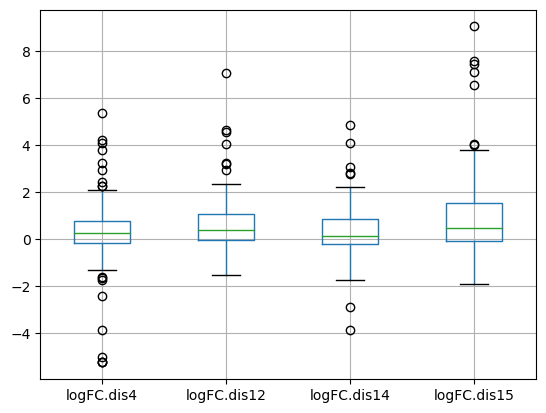

In [85]:
rnaseq_gml_subT.boxplot(column=['logFC.dis4', 'logFC.dis12', 'logFC.dis14', 'logFC.dis15'])

<AxesSubplot: >

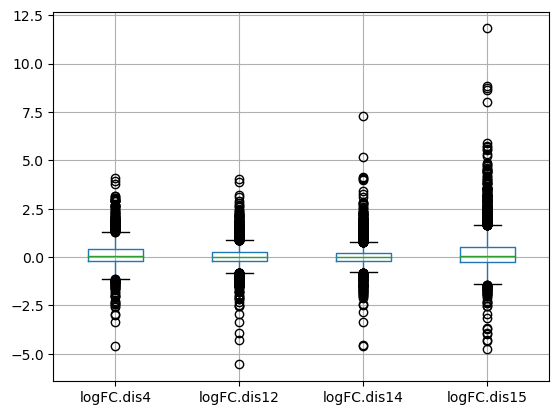

In [86]:
rnaseq_gml_notsubT.boxplot(column=['logFC.dis4', 'logFC.dis12', 'logFC.dis14', 'logFC.dis15'])  

In [142]:
print('Dis4: ' + str(ranksums(rnaseq_gml_notsubT['logFC.dis4'], rnaseq_gml_subT['logFC.dis4'])))
print('Dis12: ' + str(ranksums(rnaseq_gml_notsubT['logFC.dis12'], rnaseq_gml_subT['logFC.dis12'])))
print('Dis14: ' + str(ranksums(rnaseq_gml_notsubT['logFC.dis14'], rnaseq_gml_subT['logFC.dis14'])))
print('Dis15: ' + str(ranksums(rnaseq_gml_notsubT['logFC.dis15'], rnaseq_gml_subT['logFC.dis15'])))

Dis4: RanksumsResult(statistic=-3.9353699178971, pvalue=8.306864819625006e-05)
Dis12: RanksumsResult(statistic=-8.573330377462394, pvalue=1.0053456248289543e-17)
Dis14: RanksumsResult(statistic=-4.545552567657182, pvalue=5.4791319812013665e-06)
Dis15: RanksumsResult(statistic=-6.881240179516594, pvalue=5.9333714423214595e-12)


In [144]:
rnaseq_gml_subT.shape

(184, 5)

# checking enrichment for sir1,2,3 regulated genes

from Ellahi aper

In [99]:
sir_genes = []
with open('sir_silenced_genes_Ellahi2015.txt', 'r') as file:
    for line in file:
        sir_genes.append(line.strip())

In [101]:
rnaseq_gml_sir = rnaseq_gml[rnaseq_gml.index.isin(sir_genes)]
# ~ revert the command!
rnaseq_gml_notsir = rnaseq_gml[~rnaseq_gml.index.isin(sir_genes)]

<AxesSubplot: >

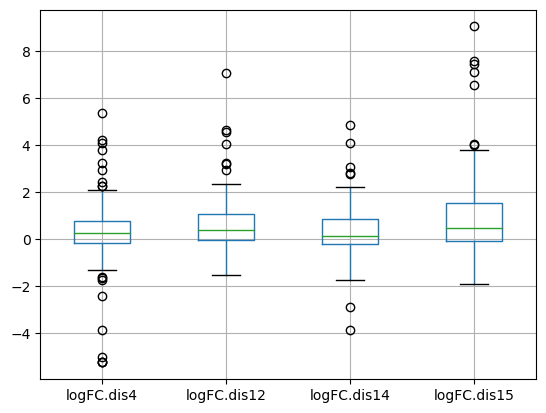

In [103]:
rnaseq_gml_subT.boxplot(column=['logFC.dis4', 'logFC.dis12', 'logFC.dis14', 'logFC.dis15'])  

<AxesSubplot: >

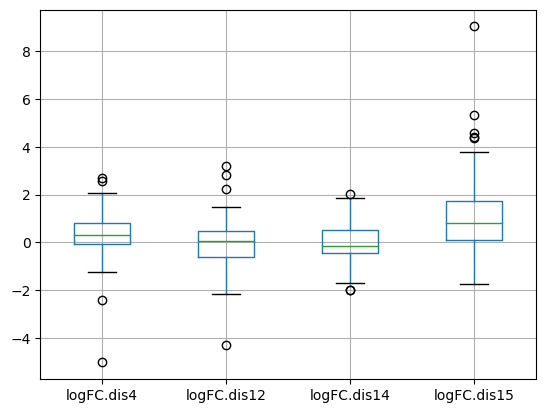

In [102]:
rnaseq_gml_sir.boxplot(column=['logFC.dis4', 'logFC.dis12', 'logFC.dis14', 'logFC.dis15'])  

In [148]:
print('Dis4: '+ str(ranksums(rnaseq_gml_notsir['logFC.dis4'], rnaseq_gml_sir['logFC.dis4'])))
print('Dis12: '+ str(ranksums(rnaseq_gml_notsir['logFC.dis12'], rnaseq_gml_sir['logFC.dis12'])))
print('Dis14: ' + str(ranksums(rnaseq_gml_notsir['logFC.dis14'], rnaseq_gml_sir['logFC.dis14'])))
print('Dis15: ' + str(ranksums(rnaseq_gml_notsir['logFC.dis15'], rnaseq_gml_sir['logFC.dis15'])))

Dis4: RanksumsResult(statistic=-3.0693846078155596, pvalue=0.0021450025119619394)
Dis12: RanksumsResult(statistic=0.3004301044759503, pvalue=0.763849103584157)
Dis14: RanksumsResult(statistic=2.4929041361691042, pvalue=0.012670304939286505)
Dis15: RanksumsResult(statistic=-7.00203078670347, pvalue=2.5227862375236835e-12)


In [145]:
rnaseq_gml_sir.shape

(95, 5)

### is subtelomeric sir-silenced genes more prone to being expressed in disomes
the genes in sir list are not all located around telomere

In [117]:
sir_subT_genes = set(subT_genes['Name']) & set(sir_genes)

In [119]:
len(sir_subT_genes)

27

In [120]:
sir_subT_gml = rnaseq_gml[rnaseq_gml.index.isin(sir_subT_genes)]
# ~ revert the command!
not_sir_subT_gml = rnaseq_gml[~rnaseq_gml.index.isin(sir_subT_genes)]

<AxesSubplot: >

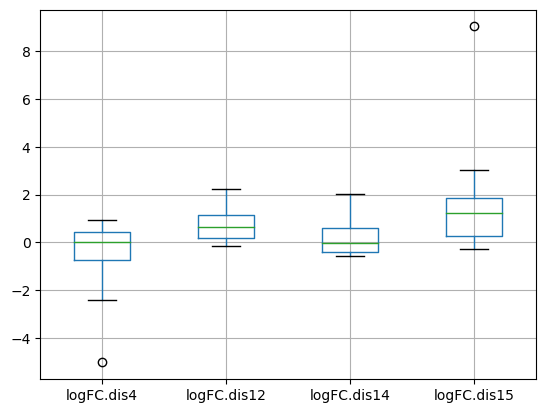

In [121]:
sir_subT_gml.boxplot(column=['logFC.dis4', 'logFC.dis12', 'logFC.dis14', 'logFC.dis15'])  

In [147]:
print('Dis4: ' + str(ranksums(sir_subT_gml['logFC.dis4'], not_sir_subT_gml['logFC.dis4'])))
print('Dis12: ' + str(ranksums(sir_subT_gml['logFC.dis12'], not_sir_subT_gml['logFC.dis12'])))
print('Dis14: ' + str(ranksums(sir_subT_gml['logFC.dis14'], not_sir_subT_gml['logFC.dis14'])))
print('Dis15: ' + str(ranksums(sir_subT_gml['logFC.dis15'], not_sir_subT_gml['logFC.dis15'])))

Dis4: RanksumsResult(statistic=-0.8852112300001552, pvalue=0.3760427166228999)
Dis12: RanksumsResult(statistic=4.409209939995129, pvalue=1.037484136461614e-05)
Dis14: RanksumsResult(statistic=-0.07616485625434768, pvalue=0.939287942090324)
Dis15: RanksumsResult(statistic=3.9936938872710814, pvalue=6.505183751141818e-05)


# Sub-telomeric genes minus the sir regulated genes.
If remaining genes are still significant, meaning there is another meachanism at play in disome telomeric derepression.
Else, it means Sir-dependent genes are te one driving the apparent derepression on subtelomeric silencing. 

In [128]:
subT_wo_sir_genes = set(subT_genes['Name']) - set(sir_genes)

In [132]:
subT_wo_sir_gml = rnaseq_gml[rnaseq_gml.index.isin(subT_wo_sir_genes)]
# ~ revert the command!
not_subT_wo_sir_gml = rnaseq_gml[~rnaseq_gml.index.isin(subT_wo_sir_genes)]

<AxesSubplot: >

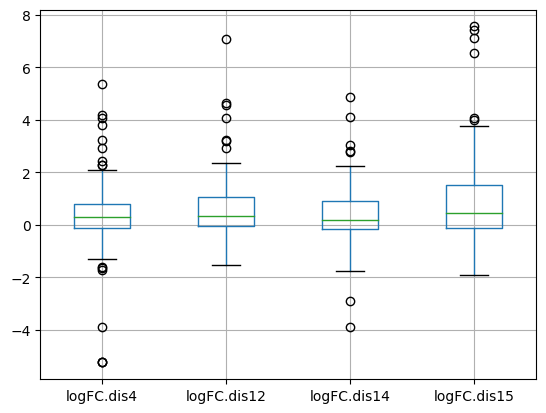

In [134]:
subT_wo_sir_gml.boxplot(column=['logFC.dis4', 'logFC.dis12', 'logFC.dis14', 'logFC.dis15'])  

In [149]:
print('Dis4: ' + str(ranksums(subT_wo_sir_gml['logFC.dis4'], not_subT_wo_sir_gml['logFC.dis4'])))
print('Dis12: ' + str(ranksums(subT_wo_sir_gml['logFC.dis12'], not_subT_wo_sir_gml['logFC.dis12'])))
print('Dis14: ' + str(ranksums(subT_wo_sir_gml['logFC.dis14'], not_subT_wo_sir_gml['logFC.dis14'])))
print('Dis15: ' + str(ranksums(subT_wo_sir_gml['logFC.dis15'], not_subT_wo_sir_gml['logFC.dis15'])))

Dis4: RanksumsResult(statistic=4.410790018468721, pvalue=1.029941584089349e-05)
Dis12: RanksumsResult(statistic=7.5606654749288165, pvalue=4.010123658288616e-14)
Dis14: RanksumsResult(statistic=4.788835981418116, pvalue=1.6775151741678656e-06)
Dis15: RanksumsResult(statistic=5.921474237189793, pvalue=3.190682958065641e-09)


So not only driven by sir genes. That's cool.
Considering that sir-controlled genes are not significant for disome 12 and 14, Sir proteins are probably not the main player in what we observed.

### sanity check
testing on random selection of the same size as subtelomeric genes population

In [109]:
random_glm = rnaseq_gml.sample(n = 184)

In [110]:
ranksums(random_glm['logFC.dis4'], rnaseq_gml['logFC.dis4'])

RanksumsResult(statistic=0.567098010957871, pvalue=0.570647594197198)

In [111]:
ranksums(random_glm['logFC.dis15'], rnaseq_gml['logFC.dis15'])

RanksumsResult(statistic=1.2318273423876465, pvalue=0.21801358723530184)